## Introduction

Palantir is an algorithm to align cells along differentiation trajectories. Palantir models differentiation as a stochastic process where stem cells differentiate to terminally differentiated cells by a series of steps through a low dimensional phenotypic manifold. Palantir effectively captures the continuity in cell states and the stochasticity in cell fate determination.

https://github.com/dpeerlab/Palantir/blob/master/notebooks/Palantir_sample_notebook.ipynb

In [1]:
import palantir
import scanpy as sc
import numpy as np
import os
#pip install rpy2
# Plotting 
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# Inline plotting
%matplotlib inline

# Reset random seed
np.random.seed(5)


findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

##  Loading data

The data consists of a subset of 40K cells processed with the FLEX single-cell assay, exported as a h5ad.

## Subsample
to make it faster for testing purposes

In [3]:
# Load sample data
palantir_dir = "./h5ad/"
ad = sc.read(palantir_dir + 'flex_subset_sorted.h5ad')
#sc.pp.subsample(ad, fraction=0.20)
ad

AnnData object with n_obs × n_vars = 39996 × 18532
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'sizeFactor', 'label', 'scDblFinder.cluster', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.difficulty', 'scDblFinder.cxds_score', 'scDblFinder.mostLikelyOrigin', 'scDblFinder.originAmbiguous', 'library', 'unintegrated_clusters', 'seurat_clusters', 'RNA_snn_res.0.2', 'barcode'
    var: 'gene_ID', 'colnames.X.'


NOTE: Counts are assumed to the normalized. If you have already normalized the data, skip past the Normalization section
## Data processing

### Normalization

Normalize the data for molecule count distribution using the scanpy interface


In [4]:
sc.pp.normalize_per_cell(ad)



We recommend that the data be log transformed. Note that, some datasets show better signal in the linear scale while others show stronger signal in the log scale.

The function below uses a pseudocount of 0.1 instead of 1.


In [5]:
#palantir.preprocess.log_transform(ad)
sc.pp.log1p(ad)


Highly variable gene selection

Highly variable gene selection can also be performed using the scanpy interface


In [6]:
sc.pp.highly_variable_genes(ad, n_top_genes=3000#, flavor='cell_ranger'
                           )

In [7]:
ad.var.highly_variable==True
ad.var.index = ad.var.gene_ID.values
ad.var

,gene_ID,colnames.X.,highly_variable,means,dispersions,dispersions_norm
OR4F5,OR4F5,OR4F5,True,0.000087,0.712297,0.989314
SAMD11,SAMD11,SAMD11,True,0.165202,0.554312,0.556714
NOC2L,NOC2L,NOC2L,False,1.179488,0.228698,-0.570927
KLHL17,KLHL17,KLHL17,False,0.184138,0.357261,0.017144
PLEKHN1,PLEKHN1,PLEKHN1,False,0.029696,0.375121,0.066048
...,...,...,...,...,...,...
ENSG00000285269,ENSG00000285269,ENSG00000285269,False,0.001758,0.381455,0.083393
ENSG00000285329,ENSG00000285329,ENSG00000285329,False,0.000475,0.288509,-0.171117
ENSG00000285447,ENSG00000285447,ENSG00000285447,False,0.348262,0.409316,-0.029815
ENSG00000286070,ENSG00000286070,ENSG00000286070,False,0.000393,0.202014,-0.407958


In [8]:
y = [i for i, x in enumerate(ad.var.highly_variable) if x]
hvg = ad.var.highly_variable[y].index
hvg

Index(['OR4F5', 'SAMD11', 'HES4', 'AGRN', 'MXRA8', 'VWA1', 'MMP23B', 'TNFRSF9',
       'ERRFI1', 'GPR157',
       ...
       'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB', 'ENSG00000164393',
       'ENSG00000184258', 'ENSG00000197558', 'ENSG00000256029',
       'ENSG00000278674'],
      dtype='object', length=3000)

### PCA

PCA is the first step in data processing for Palantir. This representation is necessary to overcome the extensive dropouts that are pervasive in single cell RNA-seq data.

Rather than use a fixed number of PCs, we recommend the use of components that explain 85% of the variance in the data after highly variable gene selection.


In [9]:
sc.pp.pca(ad, n_comps = 30)

In [10]:
ad

AnnData object with n_obs × n_vars = 39996 × 18532
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'sizeFactor', 'label', 'scDblFinder.cluster', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.difficulty', 'scDblFinder.cxds_score', 'scDblFinder.mostLikelyOrigin', 'scDblFinder.originAmbiguous', 'library', 'unintegrated_clusters', 'seurat_clusters', 'RNA_snn_res.0.2', 'barcode', 'n_counts'
    var: 'gene_ID', 'colnames.X.', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [11]:
ad.obs

,orig.ident,nCount_RNA,nFeature_RNA,sample,sum,detected,subsets_Mito_sum,subsets_Mito_detected,subsets_Mito_percent,total,...,scDblFinder.difficulty,scDblFinder.cxds_score,scDblFinder.mostLikelyOrigin,scDblFinder.originAmbiguous,library,unintegrated_clusters,seurat_clusters,RNA_snn_res.0.2,barcode,n_counts
iESC_0h_TGTCGAGAGGTCAAACACTTTAGG-1,iESC,12794.0,5620.0,iESC_0h,12794.0,5620,51.0,11,0.398624,12794.0,...,0.016518,0.022081,2+6,True,B1,0,2,2,iESC_0h_TGTCGAGAGGTCAAACACTTTAGG-1,12794.0
iESC_0h_CTGATTTAGCTTTACGACTTTAGG-1,iESC,17544.0,6344.0,iESC_0h,17544.0,6344,88.0,12,0.501596,17544.0,...,0.005375,0.416197,3+6,False,B1,0,0,0,iESC_0h_CTGATTTAGCTTTACGACTTTAGG-1,17544.0
iESC_0h_TAAAGGGAGGACAACTACTTTAGG-1,iESC,13058.0,5442.0,iESC_0h,13058.0,5442,141.0,11,1.079798,13058.0,...,0.030878,0.182323,5+6,False,B1,0,2,2,iESC_0h_TAAAGGGAGGACAACTACTTTAGG-1,13058.0
iESC_0h_ACGCCACGTGTGTCGCACTTTAGG-1,iESC,20207.0,6742.0,iESC_0h,20207.0,6742,381.0,12,1.885485,20207.0,...,0.010337,0.396759,4+5,False,B1,0,0,0,iESC_0h_ACGCCACGTGTGTCGCACTTTAGG-1,20207.0
iESC_0h_AGCGAAGCACACTAAGACTTTAGG-1,iESC,21444.0,6931.0,iESC_0h,21444.0,6931,226.0,12,1.053908,21444.0,...,0.010647,0.544380,2+5,True,B1,0,0,0,iESC_0h_AGCGAAGCACACTAAGACTTTAGG-1,21444.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
iESC_120h_TCTAACCCAGGGCTATATGTTGAC-1,iESC,8602.0,4338.0,iESC_120h,8602.0,4338,28.0,9,0.325506,8602.0,...,0.092402,0.198201,1+16,False,B2,3,5,5,iESC_120h_TCTAACCCAGGGCTATATGTTGAC-1,8602.0
iESC_120h_CGCAGCACAATCCACTATGTTGAC-1,iESC,11036.0,4733.0,iESC_120h,11036.0,4733,33.0,9,0.299021,11036.0,...,0.135098,0.108419,11+14,False,B2,3,5,5,iESC_120h_CGCAGCACAATCCACTATGTTGAC-1,11036.0
iESC_120h_AGTAGGCGTGCTGCACATGTTGAC-1,iESC,8428.0,4231.0,iESC_120h,8428.0,4231,42.0,10,0.498339,8428.0,...,0.067585,0.107422,2+4,False,B2,3,5,5,iESC_120h_AGTAGGCGTGCTGCACATGTTGAC-1,8428.0
iESC_120h_GTGGCGAGTGAGTAATATGTTGAC-1,iESC,14254.0,5455.0,iESC_120h,14254.0,5455,12.0,6,0.084187,14254.0,...,0.056300,0.171696,13+8,False,B2,9,4,4,iESC_120h_GTGGCGAGTGAGTAATATGTTGAC-1,14254.0


In [12]:
pca_projections = pd.DataFrame(data=ad.obsm['X_pca'],   # values
                               index=ad.obs.index)    # 1st row as the column names

In [13]:
pca_projections

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
iESC_0h_TGTCGAGAGGTCAAACACTTTAGG-1,-9.108181,-0.833773,-2.874861,-2.479164,-3.255537,0.694227,2.921785,1.501936,0.547605,2.058692,...,0.155553,1.004870,0.243224,0.974375,-0.615668,-0.583933,-1.441998,0.124198,-0.967224,0.085699
iESC_0h_CTGATTTAGCTTTACGACTTTAGG-1,-9.271157,-0.816874,-3.711222,-1.951480,-2.364430,-0.564958,2.235779,-3.366462,-0.098680,-0.327735,...,-1.380998,0.871799,-0.498396,0.899301,-0.044835,-1.029366,1.395450,-0.265044,0.250511,0.850795
iESC_0h_TAAAGGGAGGACAACTACTTTAGG-1,-9.821233,-0.281088,-3.554456,-2.995885,-3.057487,-0.853610,2.235147,-4.860878,-1.888428,-0.667288,...,1.802174,0.917109,-0.519163,0.925859,0.682404,1.204824,-0.902620,-0.228705,-0.156800,0.800313
iESC_0h_ACGCCACGTGTGTCGCACTTTAGG-1,-9.703450,-0.848909,-2.300018,-2.060372,-1.892518,-0.310347,1.652776,-2.795583,-0.638512,-1.392065,...,0.685417,-0.908980,-0.123416,0.608315,0.808079,0.824096,-1.232191,-0.755644,0.160710,0.661874
iESC_0h_AGCGAAGCACACTAAGACTTTAGG-1,-9.450584,-0.903607,-3.587633,-1.974189,-2.107610,-0.186436,1.316927,-1.889261,-0.515609,-2.541809,...,-0.635921,0.902669,-0.628833,1.141225,0.523261,0.232567,-0.548678,-0.411069,0.145365,0.793270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
iESC_120h_TCTAACCCAGGGCTATATGTTGAC-1,18.206411,-9.520619,0.665538,-0.747175,-0.603418,2.347508,4.692258,-3.152004,0.293757,3.497229,...,-1.098059,1.176138,1.823219,1.238679,0.151583,0.499873,-0.665944,-2.414695,0.443256,0.620147
iESC_120h_CGCAGCACAATCCACTATGTTGAC-1,19.763680,-9.973253,0.647791,3.525820,-3.058269,-0.993722,6.687719,-1.868012,-1.022654,5.721504,...,2.523890,0.486088,0.621749,0.244008,2.493350,-1.156192,1.304638,-0.450213,0.425252,2.277491
iESC_120h_AGTAGGCGTGCTGCACATGTTGAC-1,19.255302,-8.453393,-0.197899,-0.788915,0.006823,2.626619,5.329625,-1.752834,-0.242763,2.968478,...,1.300187,3.469491,0.424187,-3.784264,2.227280,0.252290,0.480287,0.784468,-0.500152,-0.156044
iESC_120h_GTGGCGAGTGAGTAATATGTTGAC-1,11.269765,-2.331631,10.022102,-4.621893,-0.468448,15.178346,5.708830,-3.841769,12.730245,-1.301674,...,1.236784,-0.039183,-1.610451,3.936524,-0.568225,-1.238945,-3.321253,1.003229,1.866829,-2.546910


## Harmony augmented affinity matrix

The following metadata information is necessary for Harmony

1.    Timepoint at which each cell was measured
2.    Connections between timepoints for computation of mutually nearest neighbors



In [14]:
tp = pd.Series(data =ad.obs['sample'], index=ad.obs['sample'].index)
tp

iESC_0h_TGTCGAGAGGTCAAACACTTTAGG-1        iESC_0h
iESC_0h_CTGATTTAGCTTTACGACTTTAGG-1        iESC_0h
iESC_0h_TAAAGGGAGGACAACTACTTTAGG-1        iESC_0h
iESC_0h_ACGCCACGTGTGTCGCACTTTAGG-1        iESC_0h
iESC_0h_AGCGAAGCACACTAAGACTTTAGG-1        iESC_0h
                                          ...    
iESC_120h_TCTAACCCAGGGCTATATGTTGAC-1    iESC_120h
iESC_120h_CGCAGCACAATCCACTATGTTGAC-1    iESC_120h
iESC_120h_AGTAGGCGTGCTGCACATGTTGAC-1    iESC_120h
iESC_120h_GTGGCGAGTGAGTAATATGTTGAC-1    iESC_120h
iESC_120h_GAGGCAACATCCCAATATGTTGAC-1    iESC_120h
Name: sample, Length: 39996, dtype: category
Categories (8, object): ['iESC_0h', 'iESC_6h', 'iESC_12h', 'iESC_24h', 'iESC_48h', 'iESC_72h', 'iESC_96h', 'iESC_120h']

In [15]:
timepoint_connections = pd.DataFrame(columns=[0,1])
index = 0
timepoint_connections.loc[index, :] = ['iESC_0h', 'iESC_6h']; index += 1
timepoint_connections.loc[index, :] = ['iESC_6h', 'iESC_12h']; index += 1
timepoint_connections.loc[index, :] = ['iESC_12h', 'iESC_24h']; index += 1
timepoint_connections.loc[index, :] = ['iESC_24h', 'iESC_48h']; index += 1
timepoint_connections.loc[index, :] = ['iESC_48h', 'iESC_72h']; index += 1
timepoint_connections.loc[index, :] = ['iESC_72h', 'iESC_96h']; index += 1
timepoint_connections.loc[index, :] = ['iESC_96h', 'iESC_120h']; index += 1


timepoint_connections

,0,1
0,iESC_0h,iESC_6h
1,iESC_6h,iESC_12h
2,iESC_12h,iESC_24h
3,iESC_24h,iESC_48h
4,iESC_48h,iESC_72h
5,iESC_72h,iESC_96h
6,iESC_96h,iESC_120h


In [16]:
data_df = pd.DataFrame(data=ad.X,   # values
                       index=ad.obs.index,
                       columns= ad.var.index
                      )    # 1st row as the column names

In [17]:
data_df

,OR4F5,SAMD11,NOC2L,KLHL17,PLEKHN1,PERM1,HES4,ISG15,AGRN,RNF223,...,ENSG00000283597,ENSG00000284824,ENSG00000284906,ENSG00000285053,ENSG00000285162,ENSG00000285269,ENSG00000285329,ENSG00000285447,ENSG00000286070,ENSG00000286265
iESC_0h_TGTCGAGAGGTCAAACACTTTAGG-1,0.0,0.000000,0.836024,0.000000,0.0,0.0,0.000000,0.000000,1.593619,0.0,...,0.0,0.0,0.000000,0.836024,0.0,0.0,0.0,0.000000,0.0,0.0
iESC_0h_CTGATTTAGCTTTACGACTTTAGG-1,0.0,0.000000,1.571329,0.669500,0.0,0.0,0.000000,0.000000,1.350610,0.0,...,0.0,0.0,0.000000,0.669500,0.0,0.0,0.0,0.000000,0.0,0.0
iESC_0h_TAAAGGGAGGACAACTACTTTAGG-1,0.0,0.000000,0.000000,0.824503,0.0,0.0,0.000000,0.824503,0.824503,0.0,...,0.0,0.0,0.000000,1.270180,0.0,0.0,0.0,0.000000,0.0,0.0
iESC_0h_ACGCCACGTGTGTCGCACTTTAGG-1,0.0,0.000000,1.636697,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.603022,0.0,0.0,0.0,0.603022,0.0,0.0
iESC_0h_AGCGAAGCACACTAAGACTTTAGG-1,0.0,0.000000,1.415748,0.939923,0.0,0.0,0.000000,0.000000,1.736837,0.0,...,0.0,0.0,0.000000,0.939923,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
iESC_120h_TCTAACCCAGGGCTATATGTTGAC-1,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.079837,1.079837,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
iESC_120h_CGCAGCACAATCCACTATGTTGAC-1,0.0,0.000000,0.922433,0.922433,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
iESC_120h_AGTAGGCGTGCTGCACATGTTGAC-1,0.0,0.000000,1.093378,0.000000,0.0,0.0,0.000000,0.000000,1.093378,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
iESC_120h_GTGGCGAGTGAGTAATATGTTGAC-1,0.0,0.000000,0.776240,0.000000,0.0,0.0,0.776240,0.776240,2.220615,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


Using the above information, the augmented and non-augmented affinity matrices can be computed using


In [18]:
import harmony
aug_aff, aff = harmony.core.augmented_affinity_matrix(pca_projections, tp,
                                                      timepoint_connections, pc_components= 10)

Running PCA with 10 components
Nearest neighbor computation...


/home/irepan/anaconda3/envs/py38/lib/python3.8/site-packages/harmony/core.py:70: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  kNN = temp.uns['neighbors']['distances']


Constucting affinities between iESC_0h and iESC_6h...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between iESC_6h and iESC_12h...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between iESC_12h and iESC_24h...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between iESC_24h and iESC_48h...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between iESC_48h and iESC_72h...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between iESC_72h and iESC_96h...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between iESC_96h and iESC_120h...
t+1 neighbors of t...
t neighbors of t+1...


In [19]:
layout = harmony.plot.force_directed_layout(aug_aff, data_df.index, iterations= 200)

100%|██████████| 200/200 [01:51<00:00,  1.79it/s]

BarnesHut Approximation  took  40.71  seconds
Repulsion forces  took  65.51  seconds
Gravitational forces  took  0.30  seconds
Attraction forces  took  2.61  seconds
AdjustSpeedAndApplyForces step  took  1.52  seconds


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


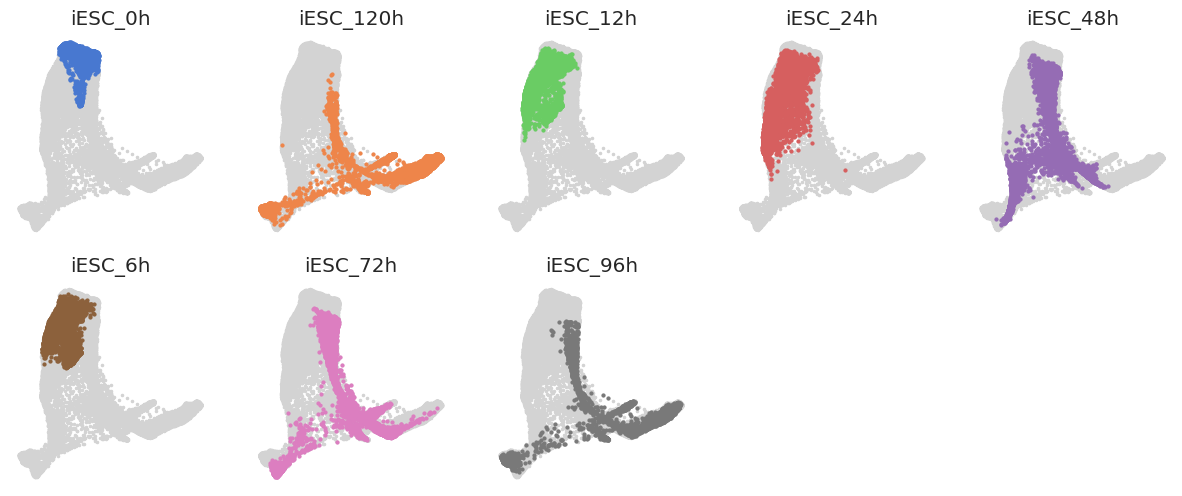

In [20]:
harmony.plot.plot_timepoints(layout, tp)

In [21]:
dm_res = palantir.utils.run_diffusion_maps(aug_aff)
ms_data = palantir.utils.determine_multiscale_space(dm_res)
ms_data.index = data_df.index

In [22]:
ad.obsm["X_dfl"] = layout.to_numpy()

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


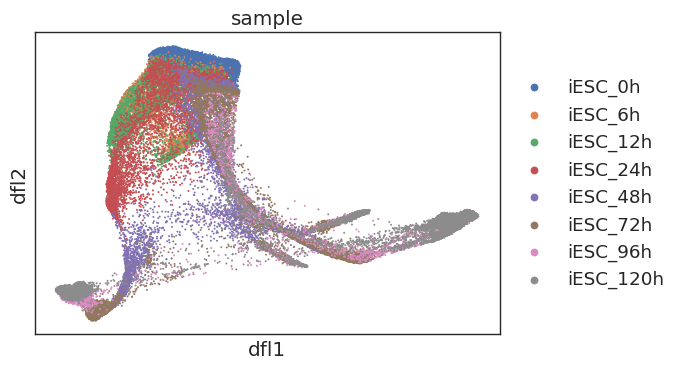

In [23]:
sc.pl.embedding(ad, basis="dfl", color="sample", size=8)

In [24]:
data_hvg = data_df.loc[:,hvg]
data_hvg

,OR4F5,SAMD11,HES4,AGRN,MXRA8,VWA1,MMP23B,TNFRSF9,ERRFI1,GPR157,...,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,ENSG00000164393,ENSG00000184258,ENSG00000197558,ENSG00000256029,ENSG00000278674
iESC_0h_TGTCGAGAGGTCAAACACTTTAGG-1,0.0,0.000000,0.000000,1.593619,0.000000,0.000000,0.000000,0.0,0.000000,0.836024,...,0.836024,1.829168,1.829168,0.000000,0.836024,0.000000,0.0,0.000000,0.0,0.0
iESC_0h_CTGATTTAGCTTTACGACTTTAGG-1,0.0,0.000000,0.000000,1.350610,0.000000,0.000000,0.000000,0.0,0.669500,0.000000,...,1.350610,1.905023,1.066957,1.066957,1.066957,0.000000,0.0,0.000000,0.0,0.0
iESC_0h_TAAAGGGAGGACAACTACTTTAGG-1,0.0,0.000000,0.000000,0.824503,0.824503,0.000000,0.000000,0.0,0.000000,0.000000,...,2.420011,2.527864,2.161538,0.000000,2.420011,0.000000,0.0,0.000000,0.0,0.0
iESC_0h_ACGCCACGTGTGTCGCACTTTAGG-1,0.0,0.000000,0.000000,0.000000,0.000000,1.247866,0.000000,0.0,1.247866,0.000000,...,2.766156,3.185267,2.766156,2.312929,3.076890,0.000000,0.0,0.000000,0.0,0.0
iESC_0h_AGCGAAGCACACTAAGACTTTAGG-1,0.0,0.000000,0.000000,1.736837,0.000000,0.939923,0.576553,0.0,1.415748,0.000000,...,2.337827,2.899090,1.589125,1.865512,1.205874,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
iESC_120h_TCTAACCCAGGGCTATATGTTGAC-1,0.0,0.000000,0.000000,1.079837,1.586865,0.000000,1.079837,0.0,1.079837,0.000000,...,1.586865,0.000000,1.079837,1.586865,1.079837,1.586865,0.0,0.000000,0.0,0.0
iESC_120h_CGCAGCACAATCCACTATGTTGAC-1,0.0,0.000000,0.000000,0.000000,0.922433,0.000000,0.000000,0.0,0.000000,0.000000,...,1.393967,1.954674,0.000000,0.922433,1.393967,1.713115,0.0,0.000000,0.0,0.0
iESC_120h_AGTAGGCGTGCTGCACATGTTGAC-1,0.0,0.000000,0.000000,1.093378,1.093378,0.000000,1.093378,0.0,0.000000,1.093378,...,2.390751,2.390751,1.093378,0.000000,1.093378,0.000000,0.0,1.093378,0.0,0.0
iESC_120h_GTGGCGAGTGAGTAATATGTTGAC-1,0.0,0.000000,0.776240,2.220615,0.000000,0.000000,0.000000,0.0,2.544185,0.000000,...,0.000000,1.508480,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0


In [25]:
color = dict(zip(range(0,15), plt.cm.tab20(range(0,15))))

In [26]:
clusters = palantir.utils.determine_cell_clusters(pca_projections)

Finding 50 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 25.438603401184082 seconds
Jaccard graph constructed in 4.122189998626709 seconds
Wrote graph to binary file in 0.7302892208099365 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.877843
After 2 runs, maximum modularity is Q = 0.880751
Louvain completed 22 runs in 23.48954439163208 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 54.152703285217285 seconds


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


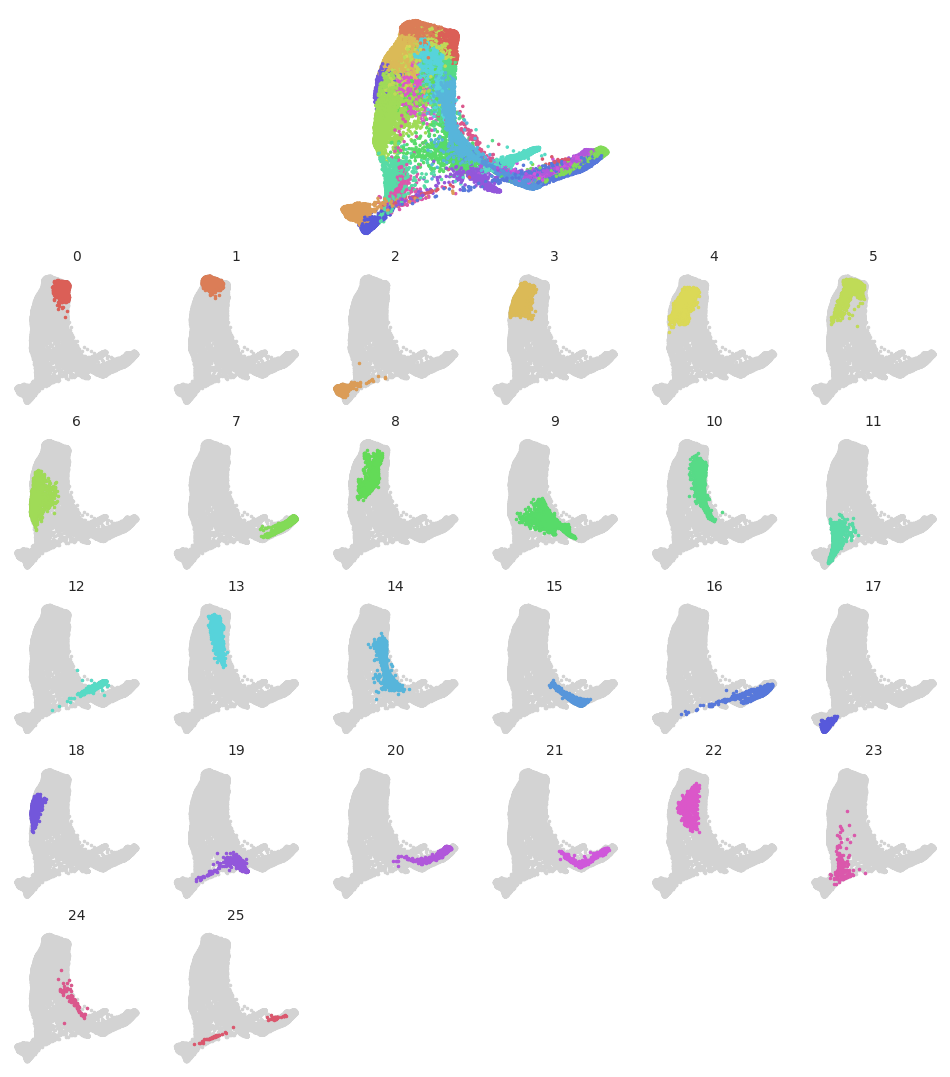

In [27]:
palantir.plot.plot_cell_clusters(layout, clusters )

In [28]:
imp_X = palantir.utils.run_magic_imputation(data_hvg, dm_res)

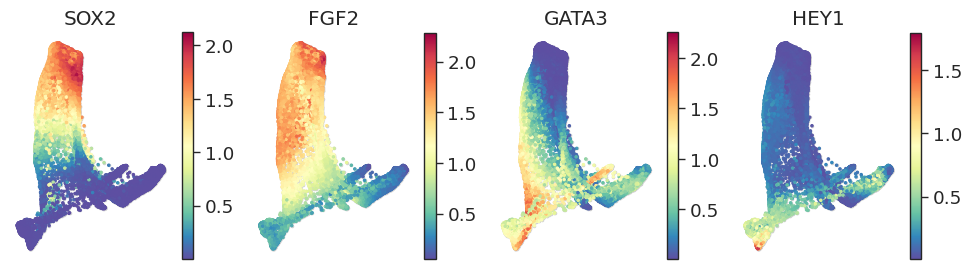

In [29]:
palantir.plot.plot_gene_expression(imp_X, layout, ['SOX2',"FGF2",'GATA3', "HEY1"], {"s": 1})

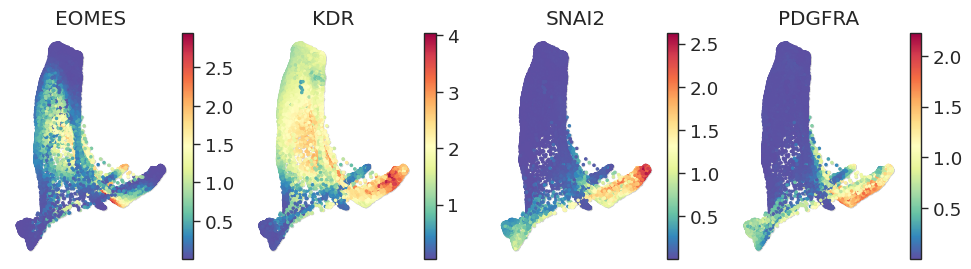

In [30]:
palantir.plot.plot_gene_expression(imp_X, layout, ['EOMES', "KDR","SNAI2", "PDGFRA"], {"s": 1})

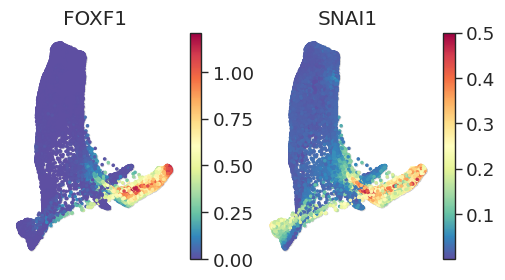

In [31]:
 palantir.plot.plot_gene_expression(imp_X, layout, ["FOXF1", "SNAI1"], {"s": 1})

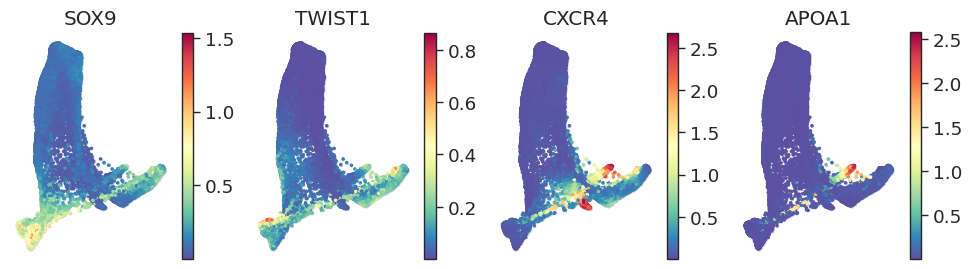

In [32]:
 palantir.plot.plot_gene_expression(imp_X, layout, ["SOX9", "TWIST1","CXCR4", "APOA1"], {"s": 1})

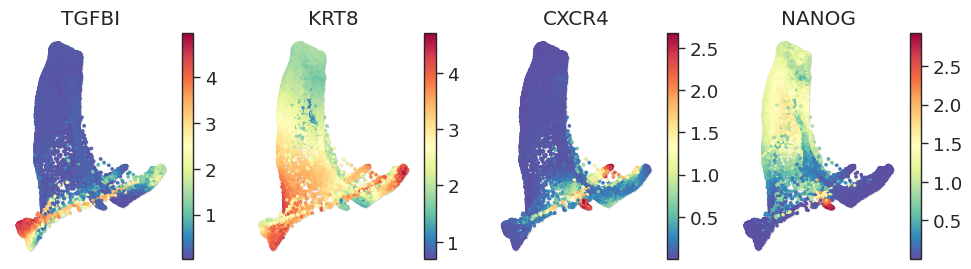

In [33]:
 palantir.plot.plot_gene_expression(imp_X, layout, ["TGFBI", "KRT8","CXCR4", "NANOG"], {"s": 1})

In [34]:
column = layout["y"]
max_value = column.idxmax()
min_value = column.idxmin()
column = layout["x"]
max_xval  = column.idxmax()
min_xval =  column.idxmin()


In [35]:
column = imp_X["APOA1"]
max_APOA1 = column.idxmax()
max_APOA1
column = imp_X["NANOG"]
max_NANOG = column.idxmax()

In [36]:
Mesoderm = max_xval
Endoderm = max_APOA1
Amnion = min_xval

(<Figure size 400x400 with 1 Axes>, <AxesSubplot:>)

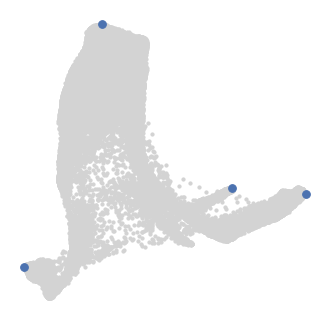

In [37]:
cells = [max_value,Mesoderm, Endoderm, Amnion]

#palantir.plot.plot_terminal_state_probs(pr_res, cells)
palantir.plot.highlight_cells_on_tsne(layout, cells)
#plt.savefig('cells.jpeg', bbox_inches='tight', dpi = 900)

##  Running Palantir

Palantir can be run by specifying an approxiate early cell.

Palantir can automatically determine the terminal states as well. In this dataset, we know the terminal states and we will set them using the terminal_states parameter

The start cell for this dataset was chosen based on high expression of CD34.


In [38]:
terminal_states = pd.Series(['Mesoderm', "Endoderm", "Amnion"], 
                           index=[Mesoderm, Endoderm, Amnion])
start_cell = max_value

In [39]:
pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=500, terminal_states=terminal_states.index)

Sampling and flocking waypoints...
Time for determining waypoints: 0.023927930990854898 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.4421237111091614 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9995
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [40]:
terminal_states

iESC_120h_CGAGCTTTCAACTGGGATGTTGAC-1    Mesoderm
iESC_120h_GCTAACGAGGTCAAGTATGTTGAC-1    Endoderm
iESC_120h_CTGAGTCTCAACCGCTATGTTGAC-1      Amnion
dtype: object

In [41]:
pr_res.branch_probs

,iESC_120h_CGAGCTTTCAACTGGGATGTTGAC-1,iESC_120h_CTGAGTCTCAACCGCTATGTTGAC-1,iESC_120h_GCTAACGAGGTCAAGTATGTTGAC-1
iESC_0h_TGTCGAGAGGTCAAACACTTTAGG-1,0.521667,0.326125,0.152208
iESC_0h_CTGATTTAGCTTTACGACTTTAGG-1,0.520189,0.327756,0.152054
iESC_0h_TAAAGGGAGGACAACTACTTTAGG-1,0.521863,0.325908,0.152228
iESC_0h_ACGCCACGTGTGTCGCACTTTAGG-1,0.518870,0.329213,0.151917
iESC_0h_AGCGAAGCACACTAAGACTTTAGG-1,0.520481,0.327435,0.152085
...,...,...,...
iESC_120h_TCTAACCCAGGGCTATATGTTGAC-1,0.902083,0.000000,0.090301
iESC_120h_CGCAGCACAATCCACTATGTTGAC-1,0.904367,0.000000,0.088206
iESC_120h_AGTAGGCGTGCTGCACATGTTGAC-1,0.902887,0.000000,0.089563
iESC_120h_GTGGCGAGTGAGTAATATGTTGAC-1,0.000000,0.000000,0.997986


### Palantir generates the following results

1.    Pseudotime: Pseudo time ordering of each cell
2.    Terminal state probabilities: Matrix of cells X terminal states. Each entry represents the probability of the corresponding cell reaching the respective terminal state
3.    Entropy: A quantiative measure of the differentiation potential of each cell computed as the entropy of the multinomial terminal state probabilities

The terminal states in this dataset are renamed to reflect the known biology below


In [42]:
pr_res.branch_probs.columns = terminal_states[pr_res.branch_probs.columns]

## Visualizing Palantir results

Palantir results can be visualized on the tSNE map using the plot_palantir_results function


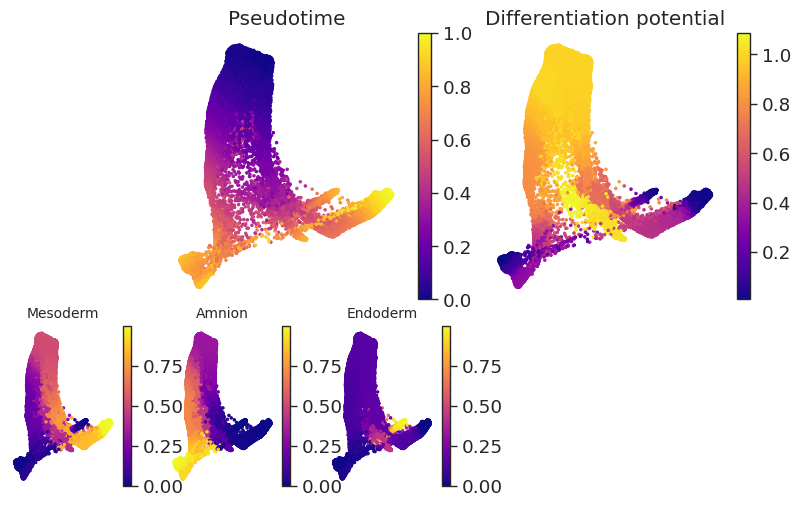

In [43]:
palantir.plot.plot_palantir_results(pr_res, layout)

### Gene expression trends

Palantir uses Generalized Additive Models (GAMs) to determine the gene expression trends along different lineages. The marker trends can be determined using the following snippet. This computes the trends for all lineages. A subset of lineages can be used using the lineages parameter.


In [44]:
goi = ["SOX2",   #"POU5F1", 
       "FOXF1", "APOA1","TGFBI", "KDR" ]
data_goi = data_df.loc[:,goi]
data_goi
imp_goi = palantir.utils.run_magic_imputation(data_goi, dm_res)

In [45]:
gene_trends = palantir.presults.compute_gene_trends( pr_res, imp_goi.loc[:, goi])

Mesoderm
Time for processing Mesoderm: 0.05111696720123291 minutes
Amnion
Time for processing Amnion: 0.03679572343826294 minutes
Endoderm
Time for processing Endoderm: 0.015011235078175863 minutes


In [46]:
gene_trends

OrderedDict([('Mesoderm',
              OrderedDict([('trends',
                                   0.000000  0.002004  0.004008  0.006012  0.008016  0.010020  0.012024  \
                            SOX2   1.772806  1.766883  1.760960  1.755037  1.749113  1.743189  1.737262   
                            FOXF1  0.000282  0.000265  0.000248  0.000231  0.000214  0.000197  0.000180   
                            APOA1  0.013968  0.013955  0.013943  0.013930  0.013918  0.013905  0.013893   
                            TGFBI  0.135709  0.135658  0.135607  0.135556  0.135505  0.135454  0.135404   
                            KDR    1.440184  1.444866  1.449549  1.454232  1.458916  1.463604  1.468295   
                            
                                   0.014028  0.016032  0.018036  ...  0.981964  0.983968  0.985972  \
                            SOX2   1.731334  1.725402  1.719467  ... -0.001265 -0.001172 -0.001079   
                            FOXF1  0.000164  0.000147  0.0001

In [47]:
keys = list(gene_trends)
keys



['Mesoderm', 'Amnion', 'Endoderm']

In [48]:
from collections import OrderedDict
keys[0], keys[1] = keys[1], keys[0]
gene_trends_ordered = OrderedDict((key, gene_trends[key]) for key in keys)
list(gene_trends_ordered)


['Amnion', 'Mesoderm', 'Endoderm']

In [49]:
gene_trends_ordered

OrderedDict([('Amnion',
              OrderedDict([('trends',
                                   0.000000  0.001876  0.003752  0.005628  0.007504  0.009381  0.011257  \
                            SOX2   1.739439  1.735466  1.731493  1.727520  1.723547  1.719573  1.715598   
                            FOXF1  0.000465  0.000492  0.000519  0.000546  0.000573  0.000600  0.000627   
                            APOA1  0.013919  0.013914  0.013908  0.013902  0.013897  0.013891  0.013886   
                            TGFBI  0.138818  0.138701  0.138585  0.138468  0.138352  0.138235  0.138119   
                            KDR    1.467689  1.469320  1.470951  1.472582  1.474214  1.475849  1.477488   
                            
                                   0.013133  0.015009  0.016885  ...  0.919293  0.921169  0.923045  \
                            SOX2   1.711622  1.707643  1.703663  ... -0.042525 -0.043375 -0.044225   
                            FOXF1  0.000654  0.000681  0.000708


The determined trends can be visualized with the plot_gene_trends function. A separate panel is generated for each gene


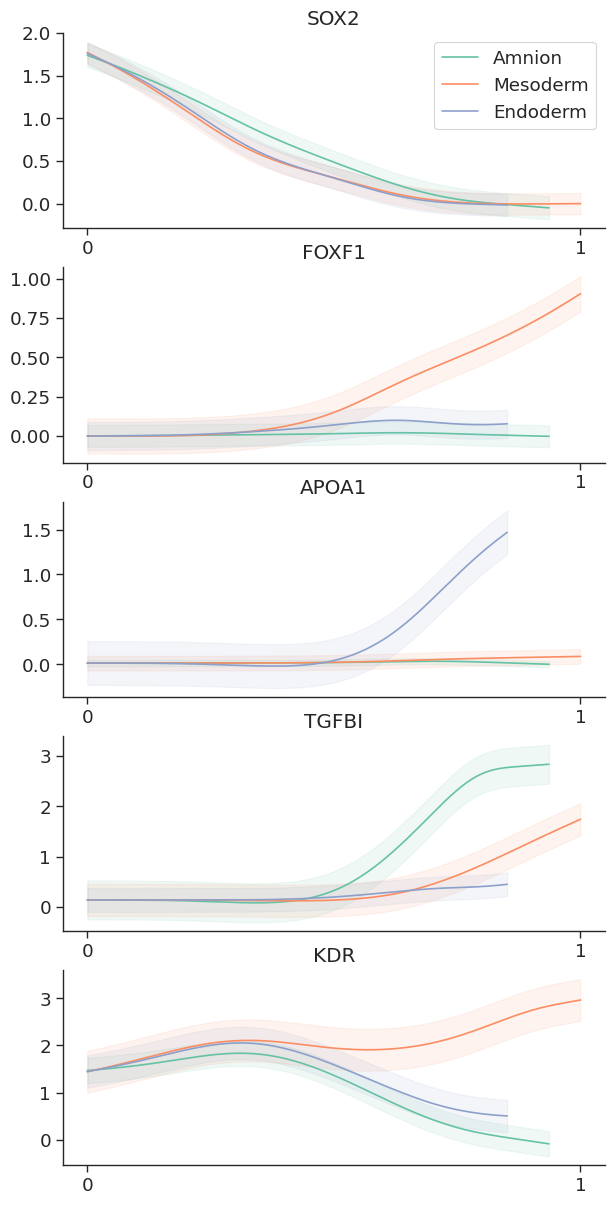

In [50]:
palantir.plot.plot_gene_trends(gene_trends_ordered)
#plt.savefig('./plots/flex_trajectories.svg', bbox_inches='tight')

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


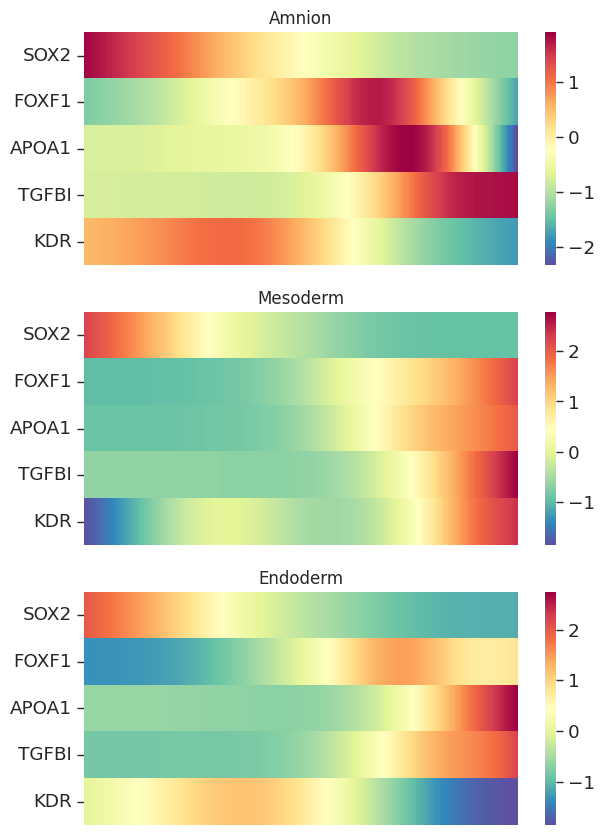

In [51]:
palantir.plot.plot_gene_trend_heatmaps(gene_trends_ordered)

## Clustering

In [52]:
clusters

iESC_0h_TGTCGAGAGGTCAAACACTTTAGG-1       5
iESC_0h_CTGATTTAGCTTTACGACTTTAGG-1       1
iESC_0h_TAAAGGGAGGACAACTACTTTAGG-1       1
iESC_0h_ACGCCACGTGTGTCGCACTTTAGG-1       1
iESC_0h_AGCGAAGCACACTAAGACTTTAGG-1       1
                                        ..
iESC_120h_TCTAACCCAGGGCTATATGTTGAC-1    16
iESC_120h_CGCAGCACAATCCACTATGTTGAC-1    16
iESC_120h_AGTAGGCGTGCTGCACATGTTGAC-1    16
iESC_120h_GTGGCGAGTGAGTAATATGTTGAC-1    12
iESC_120h_GAGGCAACATCCCAATATGTTGAC-1    12
Length: 39996, dtype: int64

In [53]:
x =pd.Series(data =clusters.astype("str"), index=ad.obs["sample"].index)
ad.obs["palantir_clusters"] = x

In [54]:
ad.obs.palantir_clusters = ad.obs.palantir_clusters.astype("str")

In [55]:
ad.obs.palantir_clusters = ad.obs.palantir_clusters.astype("category")

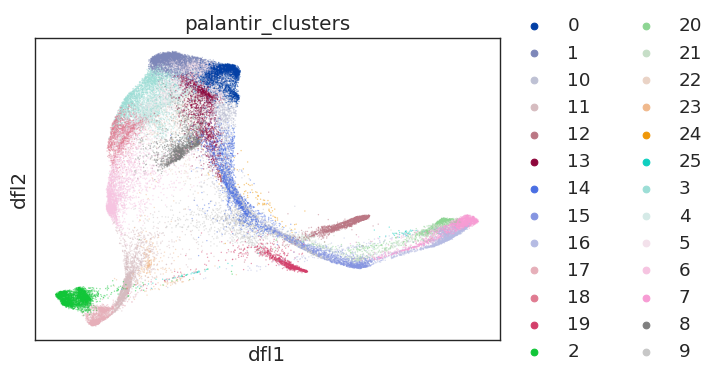

In [56]:
sc.pl.embedding(ad, basis="dfl", color="palantir_clusters", size=4, alpha= 0.5)

In [57]:
sc.tl.rank_genes_groups(ad, groupby="palantir_clusters",use_raw=False)

/home/irepan/anaconda3/envs/py38/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/irepan/anaconda3/envs/py38/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/irepan/anaconda3/envs/py38/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of cal

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


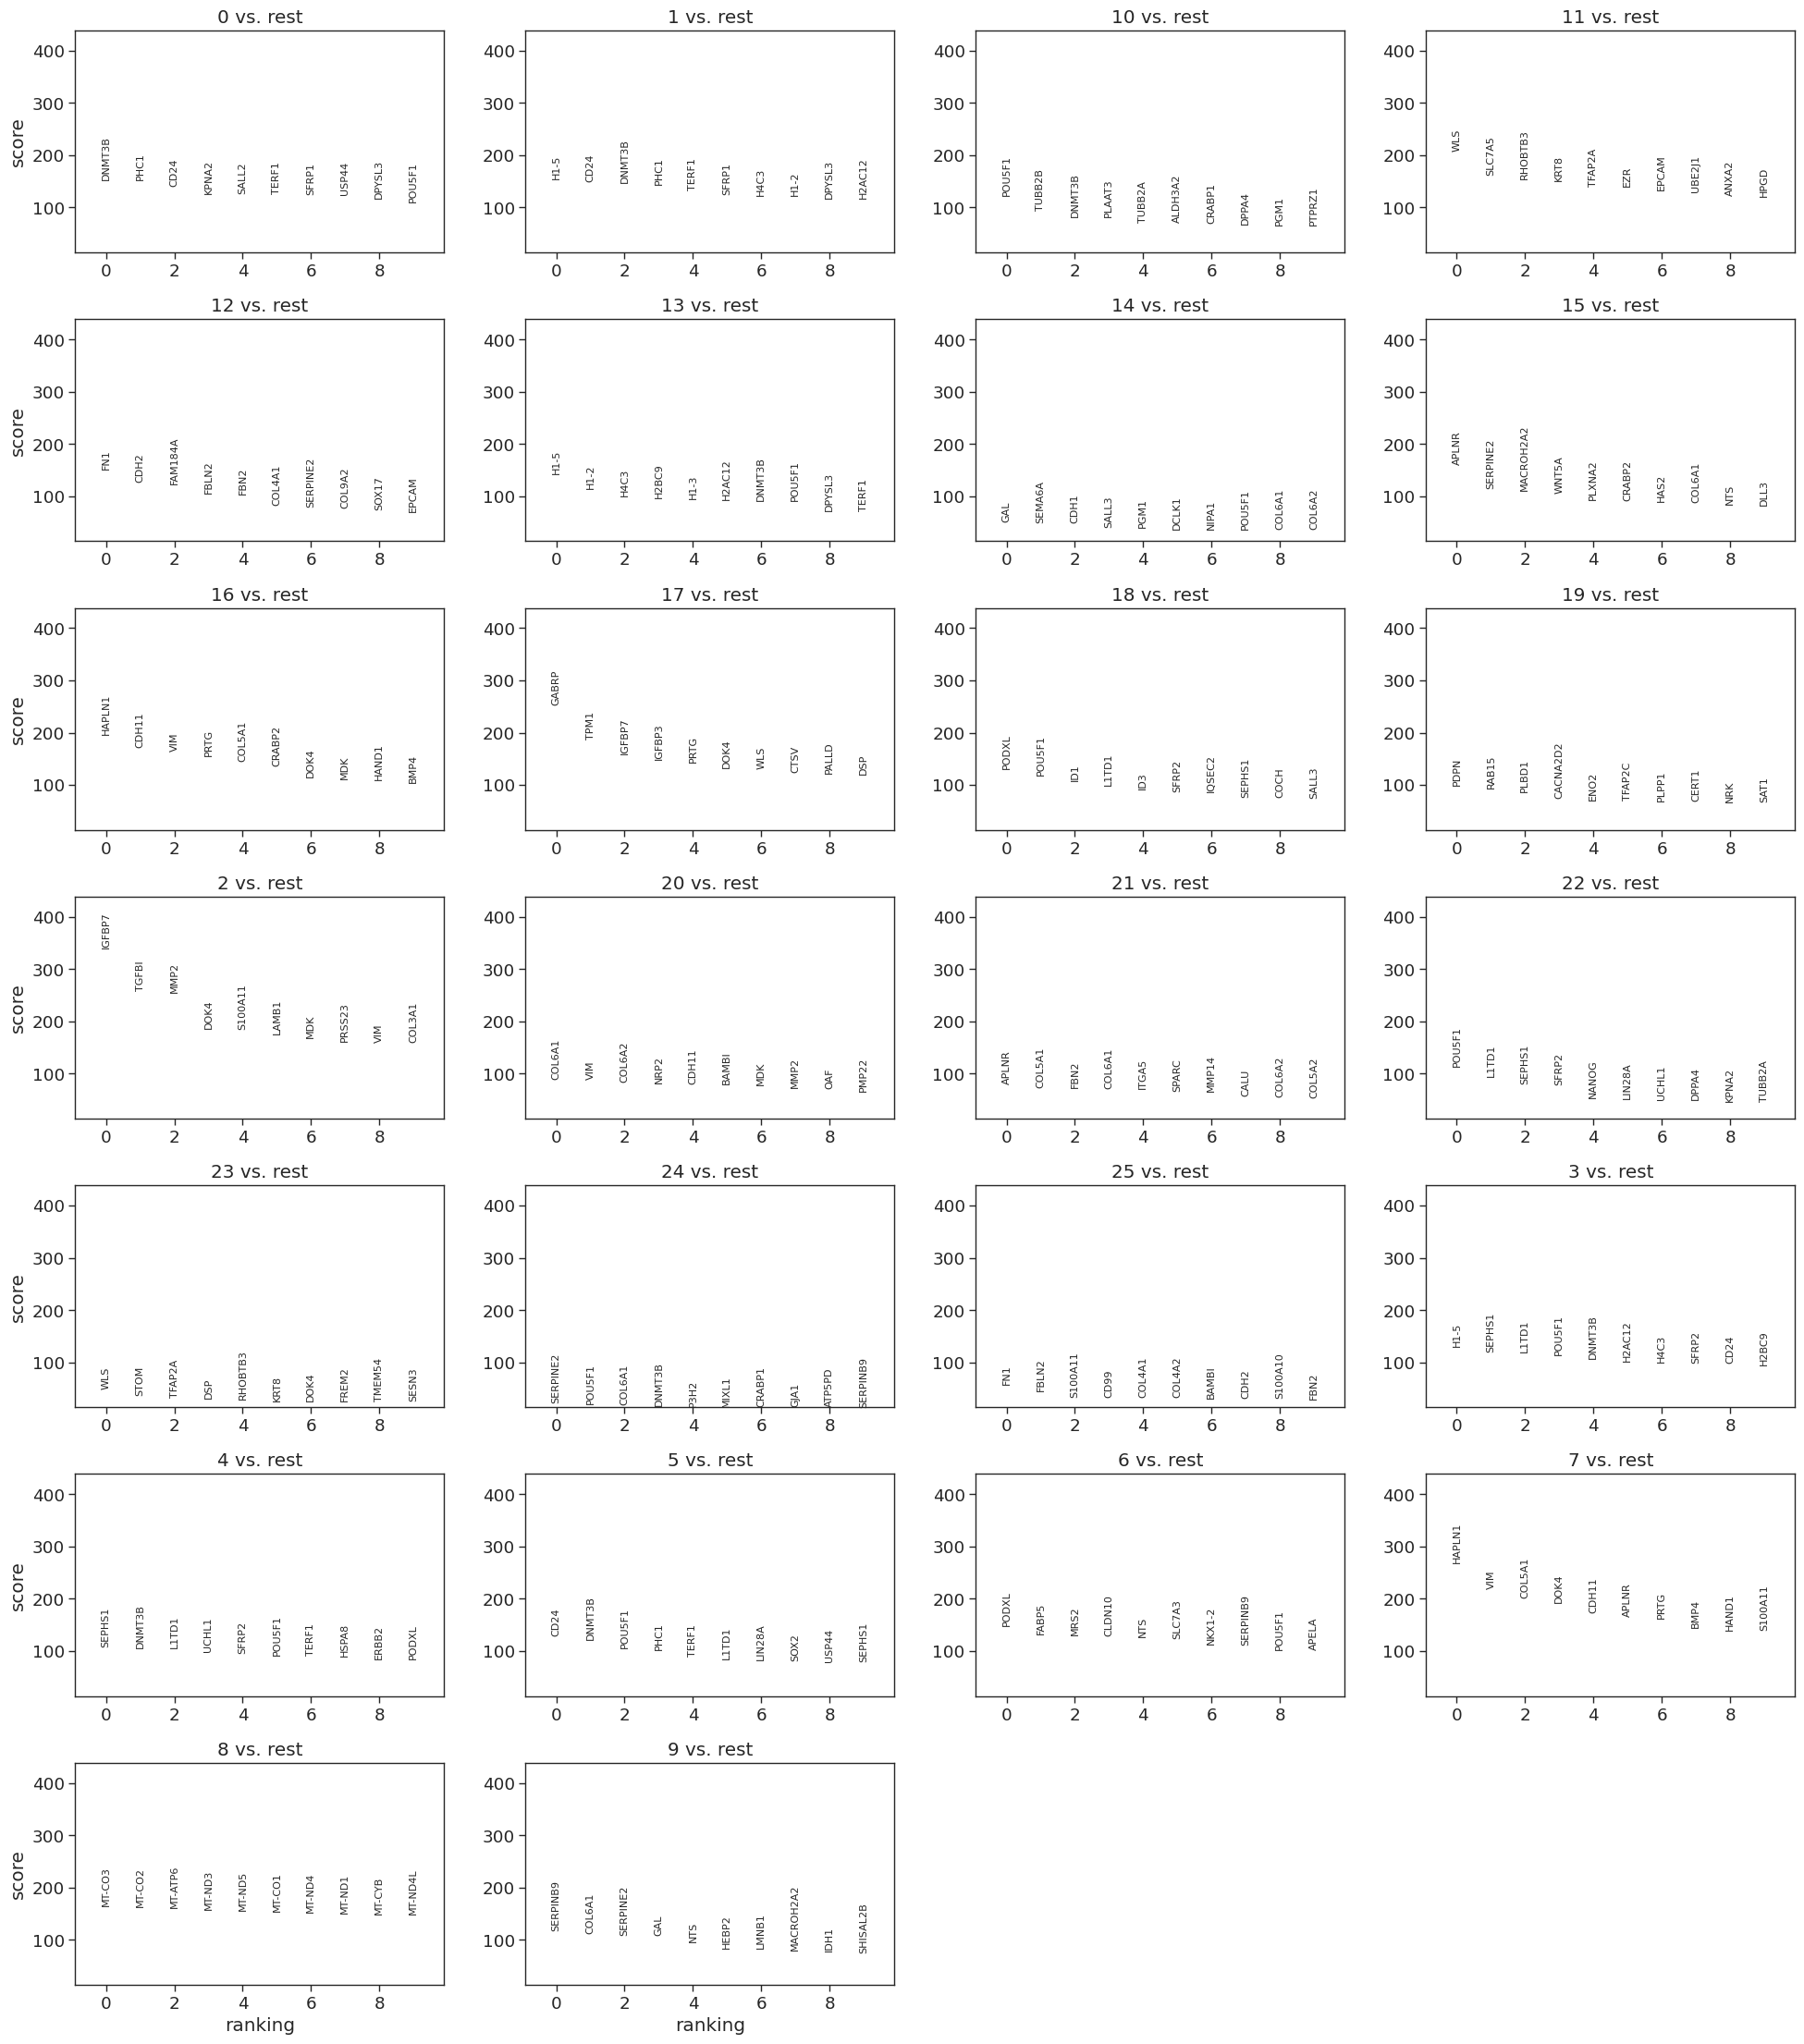

In [58]:
sc.pl.rank_genes_groups(ad, n_genes=10)

ad.X.columns[[18779,15920,19958,13360,6300,32199,27460,21508,7865]]

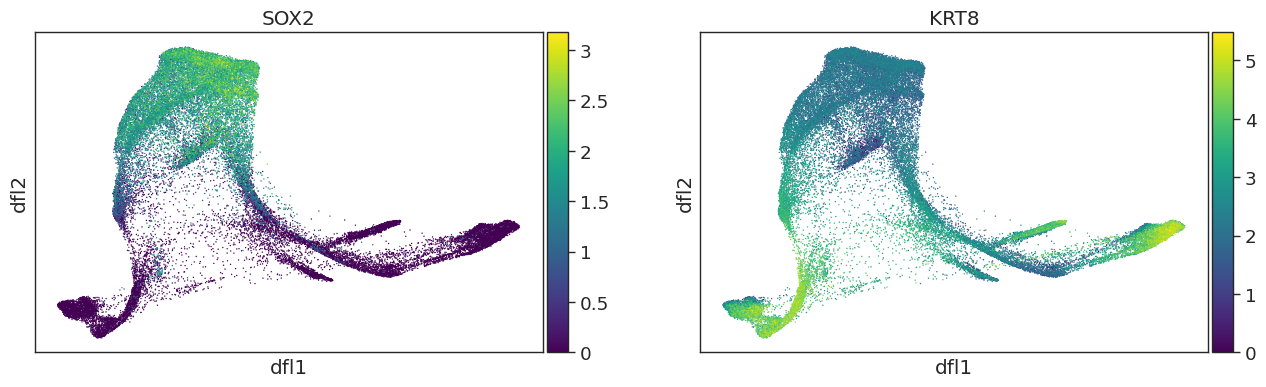

In [59]:
sc.pl.scatter(ad, basis="dfl",
              color=['SOX2', 'KRT8'],
              use_raw=False,size = 4, color_map="viridis" )

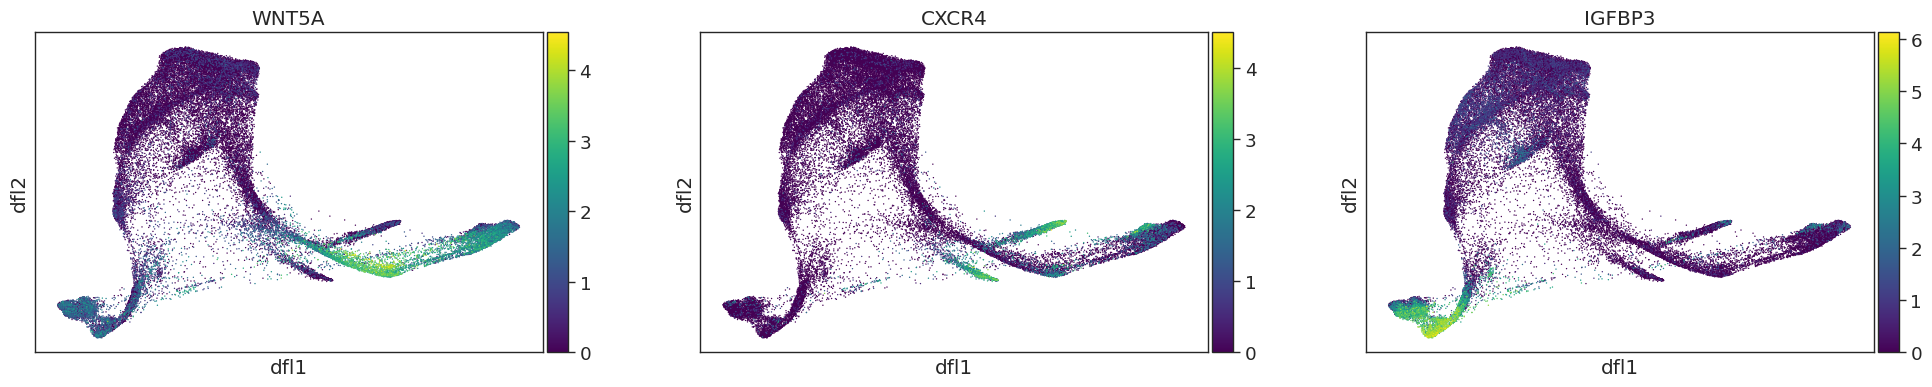

In [60]:
sc.pl.scatter(ad, basis="dfl",
              color=['WNT5A', 'CXCR4', "IGFBP3"],
              use_raw=False,size = 4 , color_map="viridis")

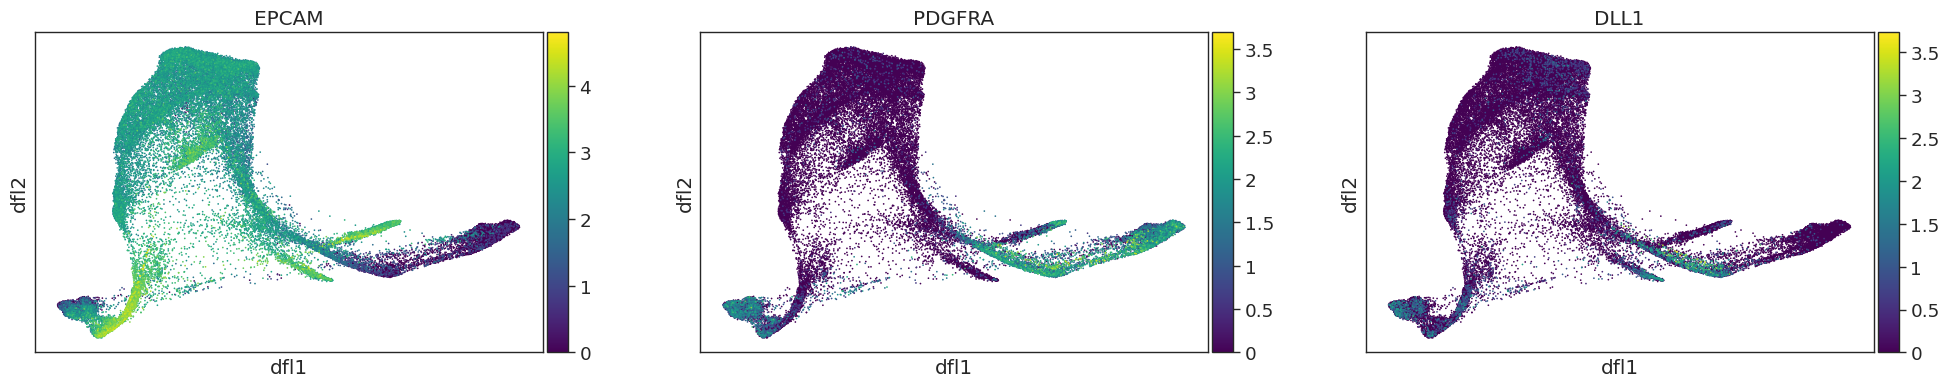

In [61]:
sc.pl.scatter(ad, basis="dfl",
              color=[ 'EPCAM','PDGFRA', "DLL1"],
              use_raw=False,size = 6, color_map="viridis" )

In [62]:
ad

AnnData object with n_obs × n_vars = 39996 × 18532
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'sum', 'detected', 'subsets_Mito_sum', 'subsets_Mito_detected', 'subsets_Mito_percent', 'total', 'sizeFactor', 'label', 'scDblFinder.cluster', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.difficulty', 'scDblFinder.cxds_score', 'scDblFinder.mostLikelyOrigin', 'scDblFinder.originAmbiguous', 'library', 'unintegrated_clusters', 'seurat_clusters', 'RNA_snn_res.0.2', 'barcode', 'n_counts', 'palantir_clusters'
    var: 'gene_ID', 'colnames.X.', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'sample_colors', 'palantir_clusters_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_dfl'
    varm: 'PCs'

In [63]:
layout

,x,y
iESC_0h_TGTCGAGAGGTCAAACACTTTAGG-1,653.975619,24350.406551
iESC_0h_CTGATTTAGCTTTACGACTTTAGG-1,-10591.156382,28785.163766
iESC_0h_TAAAGGGAGGACAACTACTTTAGG-1,-7127.632533,28968.946855
iESC_0h_ACGCCACGTGTGTCGCACTTTAGG-1,-10010.573297,30005.412911
iESC_0h_AGCGAAGCACACTAAGACTTTAGG-1,-7928.017139,30492.947499
...,...,...
iESC_120h_TCTAACCCAGGGCTATATGTTGAC-1,41284.654242,-22020.945717
iESC_120h_CGCAGCACAATCCACTATGTTGAC-1,41698.191825,-21873.654841
iESC_120h_AGTAGGCGTGCTGCACATGTTGAC-1,40772.313747,-22101.662219
iESC_120h_GTGGCGAGTGAGTAATATGTTGAC-1,29435.010112,-14067.467107


In [64]:
#np.savetxt("./csv/dfl_flex_palantir_oct24.csv", layout, delimiter=",")

In [65]:
layout.index

Index(['iESC_0h_TGTCGAGAGGTCAAACACTTTAGG-1',
       'iESC_0h_CTGATTTAGCTTTACGACTTTAGG-1',
       'iESC_0h_TAAAGGGAGGACAACTACTTTAGG-1',
       'iESC_0h_ACGCCACGTGTGTCGCACTTTAGG-1',
       'iESC_0h_AGCGAAGCACACTAAGACTTTAGG-1',
       'iESC_0h_CGTCCATAGATAACGCACTTTAGG-1',
       'iESC_0h_CGGTGAGGTAGCCATTACTTTAGG-1',
       'iESC_0h_CCTAAGCTCTAATTGCACTTTAGG-1',
       'iESC_0h_CGTTATGTCATGACAAACTTTAGG-1',
       'iESC_0h_GGTCATTGTTGAGTCTACTTTAGG-1',
       ...
       'iESC_120h_GAAGGCTGTATAGTGGATGTTGAC-1',
       'iESC_120h_GACCAATAGTGGCTTCATGTTGAC-1',
       'iESC_120h_TATACCTAGCAAATCAATGTTGAC-1',
       'iESC_120h_GGATCCGCATAGACGCATGTTGAC-1',
       'iESC_120h_GGCTTGTTCTCAAGAAATGTTGAC-1',
       'iESC_120h_TCTAACCCAGGGCTATATGTTGAC-1',
       'iESC_120h_CGCAGCACAATCCACTATGTTGAC-1',
       'iESC_120h_AGTAGGCGTGCTGCACATGTTGAC-1',
       'iESC_120h_GTGGCGAGTGAGTAATATGTTGAC-1',
       'iESC_120h_GAGGCAACATCCCAATATGTTGAC-1'],
      dtype='object', length=39996)

In [66]:
ad.obs

,orig.ident,nCount_RNA,nFeature_RNA,sample,sum,detected,subsets_Mito_sum,subsets_Mito_detected,subsets_Mito_percent,total,...,scDblFinder.cxds_score,scDblFinder.mostLikelyOrigin,scDblFinder.originAmbiguous,library,unintegrated_clusters,seurat_clusters,RNA_snn_res.0.2,barcode,n_counts,palantir_clusters
iESC_0h_TGTCGAGAGGTCAAACACTTTAGG-1,iESC,12794.0,5620.0,iESC_0h,12794.0,5620,51.0,11,0.398624,12794.0,...,0.022081,2+6,True,B1,0,2,2,iESC_0h_TGTCGAGAGGTCAAACACTTTAGG-1,12794.0,5
iESC_0h_CTGATTTAGCTTTACGACTTTAGG-1,iESC,17544.0,6344.0,iESC_0h,17544.0,6344,88.0,12,0.501596,17544.0,...,0.416197,3+6,False,B1,0,0,0,iESC_0h_CTGATTTAGCTTTACGACTTTAGG-1,17544.0,1
iESC_0h_TAAAGGGAGGACAACTACTTTAGG-1,iESC,13058.0,5442.0,iESC_0h,13058.0,5442,141.0,11,1.079798,13058.0,...,0.182323,5+6,False,B1,0,2,2,iESC_0h_TAAAGGGAGGACAACTACTTTAGG-1,13058.0,1
iESC_0h_ACGCCACGTGTGTCGCACTTTAGG-1,iESC,20207.0,6742.0,iESC_0h,20207.0,6742,381.0,12,1.885485,20207.0,...,0.396759,4+5,False,B1,0,0,0,iESC_0h_ACGCCACGTGTGTCGCACTTTAGG-1,20207.0,1
iESC_0h_AGCGAAGCACACTAAGACTTTAGG-1,iESC,21444.0,6931.0,iESC_0h,21444.0,6931,226.0,12,1.053908,21444.0,...,0.544380,2+5,True,B1,0,0,0,iESC_0h_AGCGAAGCACACTAAGACTTTAGG-1,21444.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
iESC_120h_TCTAACCCAGGGCTATATGTTGAC-1,iESC,8602.0,4338.0,iESC_120h,8602.0,4338,28.0,9,0.325506,8602.0,...,0.198201,1+16,False,B2,3,5,5,iESC_120h_TCTAACCCAGGGCTATATGTTGAC-1,8602.0,16
iESC_120h_CGCAGCACAATCCACTATGTTGAC-1,iESC,11036.0,4733.0,iESC_120h,11036.0,4733,33.0,9,0.299021,11036.0,...,0.108419,11+14,False,B2,3,5,5,iESC_120h_CGCAGCACAATCCACTATGTTGAC-1,11036.0,16
iESC_120h_AGTAGGCGTGCTGCACATGTTGAC-1,iESC,8428.0,4231.0,iESC_120h,8428.0,4231,42.0,10,0.498339,8428.0,...,0.107422,2+4,False,B2,3,5,5,iESC_120h_AGTAGGCGTGCTGCACATGTTGAC-1,8428.0,16
iESC_120h_GTGGCGAGTGAGTAATATGTTGAC-1,iESC,14254.0,5455.0,iESC_120h,14254.0,5455,12.0,6,0.084187,14254.0,...,0.171696,13+8,False,B2,9,4,4,iESC_120h_GTGGCGAGTGAGTAATATGTTGAC-1,14254.0,12


In [67]:
#layout.to_csv("./csv/dfl_flex_palantir_coords_oct24.csv")

In [68]:
#ad.obs.to_csv("./csv/dfl_flex_palantir_metadata_oct24.csv")

In [69]:
#ad.write(filename="./h5ad/dfl_flex_subset_sorted_dfl_Oct2024.h5ad")